In [1]:
import pandas as pd 
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from datetime import datetime, timedelta, time

In [2]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
def build_model(num_units, n_steps, n_features):
  model = Sequential()
  model.add(LSTM(num_units, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(num_units, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [4]:
def get_model_input(df, n_steps = 8,n_features = 1):
  try:
    raw_seq = df
    X, y = split_sequence(raw_seq, n_steps) 
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return raw_seq,X,y
  except:
    print("Exception for ", X)

In [5]:
df_path = "/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/partial_full.csv"
def read_df(my_path):
  df = pd.read_csv(my_path,infer_datetime_format=True)
  df["dt"] = pd.to_datetime(df["dt"])
  df = df.set_index("dt")
  df = df.sort_index()
  return df

In [6]:
df = read_df(df_path)
df = df.sort_index()
values = df["demand"].values.tolist()[0:]
train = values[:18000]
test = values[18000:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
#scaler.fit(train)
#scaled_train = scaler.transform(train)
#scaled_test = scaler.transform(test)

In [8]:
def prepare_model(values, n_steps = 8, n_features = 1, n_units = 50, num_epochs=200):
  raw_seq, X, y = get_model_input(values, n_steps, n_features)
  model = build_model(n_units, n_steps, n_features)
  history = model.fit(X, y, epochs=num_epochs, verbose=0)
  return model, history

In [9]:
def predict_model(values, model,n_steps=8):
  output = pd.DataFrame()
  for i in range(len(values) - n_steps - 1):
    lst = values[i:i+n_steps]
    y = values[i+n_steps]
    x_inputs = np.array(lst)
    x_input_reshaped = x_inputs.reshape((1, n_steps, 1))
    yhat = model.predict(x_input_reshaped, verbose=0)
    if y > 0:
      output = output.append({"Actual Demand": y, "Predicted Demand": yhat[0][0]}, ignore_index=True)
  return output

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt


In [11]:
def evl(train, model, n_steps):
  output = predict_model(train, model, n_steps)
  rmse=sqrt(mean_squared_error(output['Actual Demand'],output['Predicted Demand']))
  return rmse, output

In [ ]:
lags = [6,8,12]
units = [20,30,40,50,60,70,80,90,100,110,120]
hyper_param_list = []
for i in lags:
  for j in units:
    hyper_param_list.append([i,j])

In [ ]:
my_models = []
for item in hyper_param_list:
  model, history = prepare_model(train, n_steps=item[0], n_features=1, n_units=item[1], num_epochs = 50)
  rmse, output = evl(test,model, n_steps=item[0])
  my_models.append({"model":model, "history":history, "rmse": rmse, "output":output})
  print(rmse, item)

352.21821994469 [6, 20]
345.04499858158175 [6, 30]
382.40098319310806 [6, 40]
344.80807836553174 [6, 50]
346.0060798693104 [6, 60]
369.18834762474927 [6, 70]
342.95231321666137 [6, 80]
337.86167548020006 [6, 90]
363.4088009342195 [6, 100]
1034.353771961475 [6, 110]
350.2303700183662 [6, 120]
359.90877979494826 [8, 20]
338.5784589015493 [8, 30]
332.91790462932283 [8, 40]
369.50787739963965 [8, 50]
344.88652332020933 [8, 60]
344.1791577877122 [8, 70]
370.7721344072286 [8, 80]
330.135218391017 [8, 90]
398.5630104740303 [8, 100]
341.3085213669643 [8, 110]
340.06650602964106 [8, 120]
348.74589325138624 [12, 20]
332.8665244685701 [12, 30]
399.0597274999316 [12, 40]
387.23480646592657 [12, 50]
338.1839179342654 [12, 60]
326.90939840440456 [12, 70]
333.6828486501001 [12, 80]
364.0115766467138 [12, 90]
362.60732963925244 [12, 100]
341.8274515147824 [12, 110]
331.92444753858047 [12, 120]


In [12]:
new_path = "/content/drive/MyDrive/LSTM_POWER_CLUSTERING/data/fl_data/pre_processed_mi_tail.csv"
new_df = read_df(new_path)
new_df.head()

,demand
dt,
2021-09-01 00:00:00,8874.0
2021-09-01 01:00:00,8513.0
2021-09-01 02:00:00,8446.0
2021-09-01 03:00:00,8398.0
2021-09-01 04:00:00,8164.0


In [13]:
model, history = prepare_model(train, n_steps=12, n_features=1, n_units=70, num_epochs = 50)



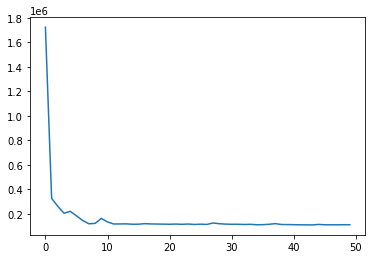

In [17]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [15]:
rmse, output = evl(new_df["demand"].values.tolist()[0:], model, n_steps=12)
print(rmse)


319.53591164560464


Text(0, 0.5, 'Demand (MW)')

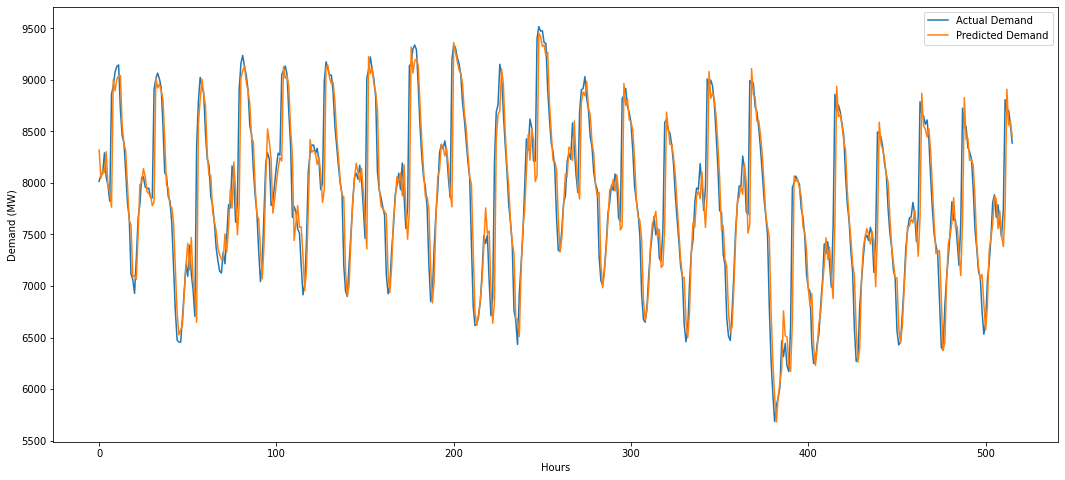

In [ ]:
ax = output.plot(figsize=(18,8))
ax.set_xlabel("Hours")
ax.set_ylabel("Demand (MW)")

349.9580978007336

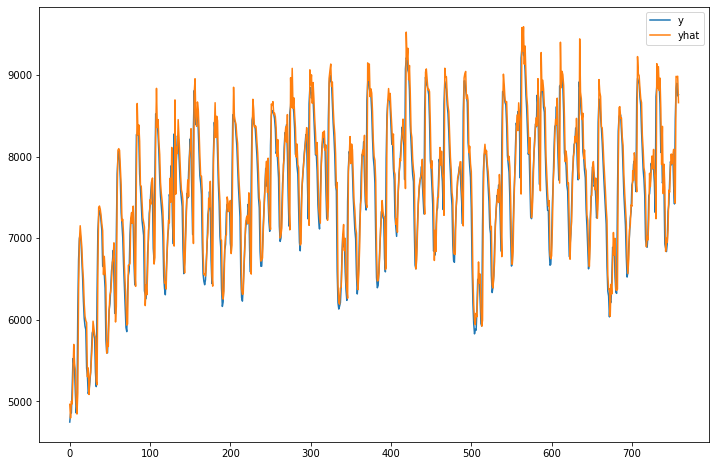

357.18387996885775

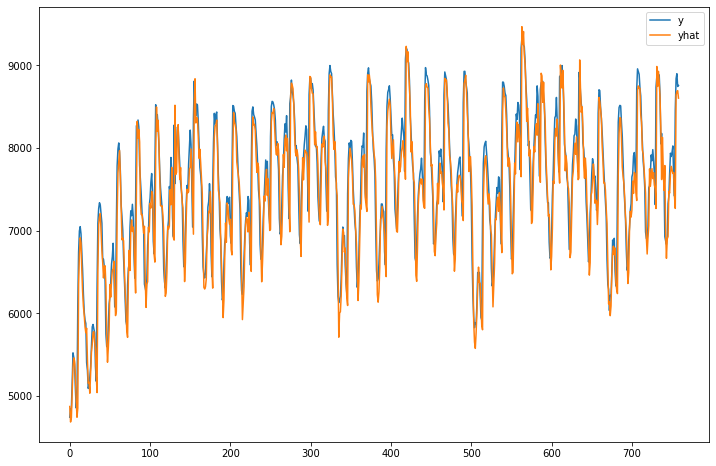

In [ ]:
model2 = prepare_model(train, n_steps = 8, n_features = 1, n_units=50, num_epochs=100)
evl(test, model2, n_steps=8)

327.05359256585393

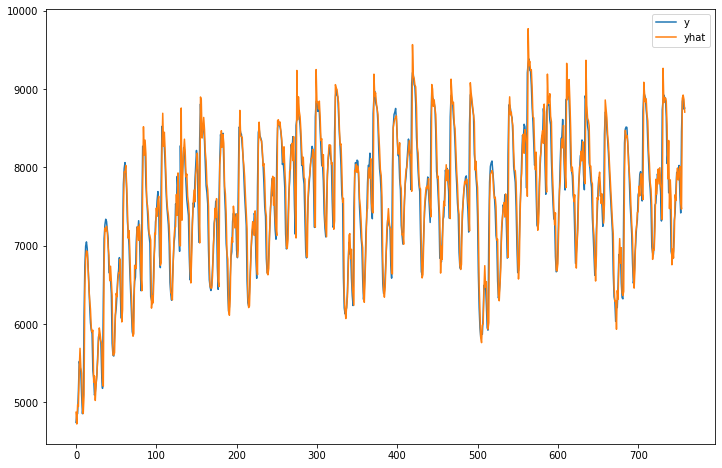

In [ ]:
model3 = prepare_model(train, n_steps = 8, n_features = 1, n_units=100, num_epochs=100)
evl(test, model3, n_steps=8)

320.69060296804724

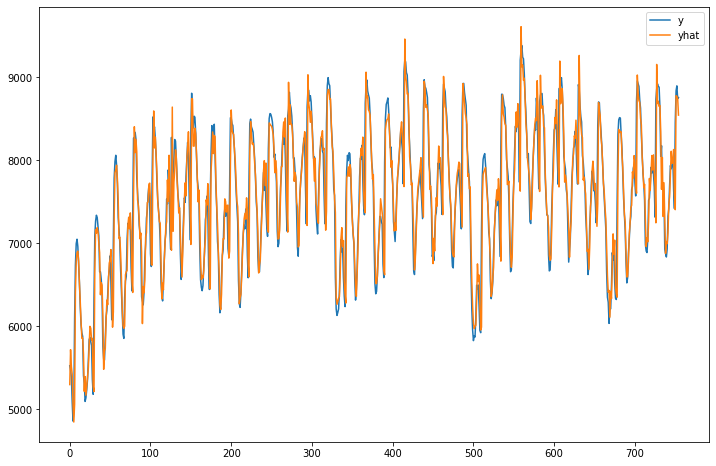

In [ ]:
model4 = prepare_model(train, n_steps = 12, n_features = 1, n_units=10, num_epochs=100)
evl(test, model4, n_steps=12)

363.55967047923684

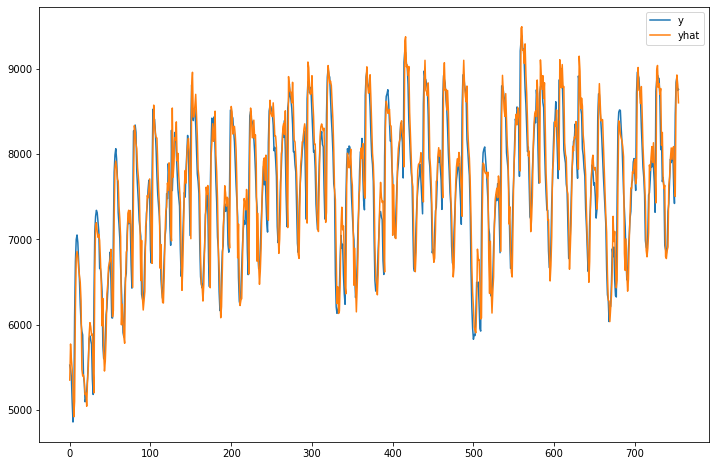

In [ ]:
model5 = prepare_model(train, n_steps = 12, n_features = 1, n_units=50, num_epochs=100)
evl(test, model5, n_steps=12)

354.9342870417886

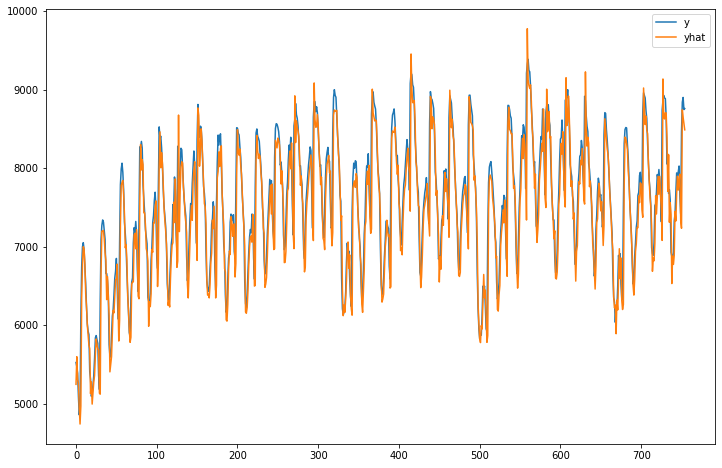

In [ ]:
model6 = prepare_model(train, n_steps = 12, n_features = 1, n_units=100, num_epochs=100)
evl(test, model6, n_steps=12)

In [ ]:
model4.save("/content/drive/MyDrive/LSTM_POWER_CLUSTERING/Models_LSTM/model_lstm")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/LSTM_POWER_CLUSTERING/Models_LSTM/model_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/LSTM_POWER_CLUSTERING/Models_LSTM/model_lstm/assets
